In [18]:
import xml.etree.ElementTree as ET
import pandas as pd
from datetime import datetime

# XML dosyasını okuma
def read_xml_data(file_path):
    # XML dosyasını yükle
    tree = ET.parse(file_path)
    root = tree.getroot()

    # Verileri saklamak için liste
    step_records = []

    # Adım kayıtlarını XML'den çıkarma
    for record in root.findall(".//Record[@type='HKQuantityTypeIdentifierStepCount']"):
        start_date = datetime.strptime(record.get('startDate'), '%Y-%m-%d %H:%M:%S %z')
        steps = int(record.get('value', 0))

        # Her kaydı listeye ekle
        step_records.append({
            'date': start_date.date(),
            'steps': steps
        })

    # DataFrame oluşturma
    df = pd.DataFrame(step_records)
    return df

# Günlük toplam adım sayısını hesaplama
def calculate_daily_steps(df):
    daily_steps = df.groupby('date')['steps'].sum().reset_index()
    return daily_steps

# Veriyi okuma ve işleme
file_path = 'export.xml'  # XML dosya yolunu buraya yazın
df = read_xml_data(file_path)
daily_steps = calculate_daily_steps(df)

# İlk birkaç satırı görüntüleme
print(daily_steps.head())


         date  steps
0  2017-07-16   2532
1  2017-07-17   1858
2  2017-07-18   1000
3  2017-07-19   1353
4  2017-07-20    467


C:\Users\asus\AppData\Local\Temp\ipykernel_12672\1455584937.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['date'] = pd.to_datetime(cleaned_data['date'])


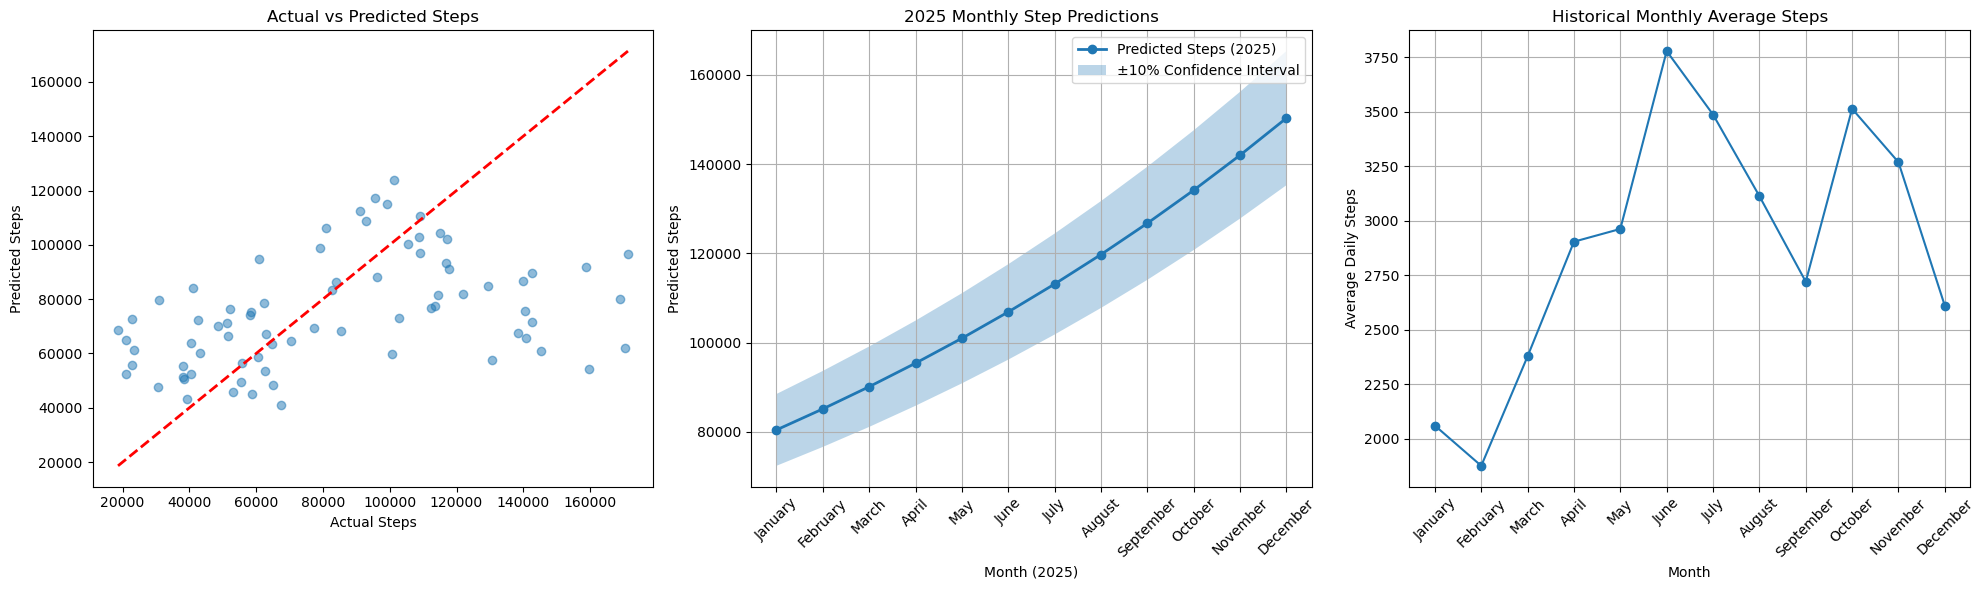

Model Performance on Training Data: MSE = 1530159014.42, R² = 0.12


In [21]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Aşırı uç değerleri tespit ve temizleme fonksiyonu
def remove_outliers(df, column, threshold=3):
    """Remove outliers based on Z-score."""
    z_scores = zscore(df[column])
    abs_z_scores = np.abs(z_scores)
    return df[abs_z_scores < threshold]

# Zaman serisi özellikleri ekleme
daily_steps['year'] = daily_steps['date'].apply(lambda x: x.year)
daily_steps['month'] = daily_steps['date'].apply(lambda x: x.month)
daily_steps['day'] = daily_steps['date'].apply(lambda x: x.day)
daily_steps['day_of_year'] = daily_steps['date'].apply(lambda x: x.timetuple().tm_yday)

# COVID-19 sürecini datasetten çıkarma
covid_start = pd.to_datetime('2020-03-13')
covid_end = pd.to_datetime('2021-03-01')
cleaned_data = daily_steps[~((pd.to_datetime(daily_steps['date']) >= covid_start) & (pd.to_datetime(daily_steps['date']) <= covid_end))]

# 2024 yılının Eylül ayına kadar olan verileri seçme
cleaned_data['date'] = pd.to_datetime(cleaned_data['date'])
cleaned_data = cleaned_data[cleaned_data['date'] <= pd.to_datetime('2024-09-30')]

# Aşırı uç değerleri temizleme
cleaned_data = remove_outliers(cleaned_data, 'steps', threshold=3)

# Aylık toplam adım sayısı hesaplama
monthly_data = cleaned_data.groupby(['year', 'month']).agg({'steps': 'sum'}).reset_index()
monthly_data['log_steps'] = np.log1p(monthly_data['steps'])

# Eğitim ve test veri setini ayırma (2025 yılı tahmini için)
train_data = monthly_data[monthly_data['year'] < 2025]
test_data = pd.DataFrame({
    'year': [2025] * 12,
    'month': np.arange(1, 13)
})

# Özellikler ve hedef değişken
X_train = train_data[['year', 'month']]
y_train = train_data['log_steps']
X_test = test_data[['year', 'month']]

# Model eğitimi
model = LinearRegression()
model.fit(X_train, y_train)

# Tahmin (logaritmik ölçekte)
test_data['log_predicted_steps'] = model.predict(X_test)

# Ters log dönüşüm (gerçek ölçekte adım sayısı)
test_data['predicted_steps'] = np.expm1(test_data['log_predicted_steps'])

# Negatif değerleri sıfıra ayarlamak yerine küçük bir minimum değere ayarla
test_data['predicted_steps'] = test_data['predicted_steps'].apply(lambda x: max(x, 100))

# Görselleştirmeler
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# 1. Actual vs Predicted Plot
ax1.scatter(np.expm1(y_train), np.expm1(model.predict(X_train)), alpha=0.5)
ax1.plot([np.expm1(y_train).min(), np.expm1(y_train).max()], 
         [np.expm1(y_train).min(), np.expm1(y_train).max()], 
         'r--', lw=2)
ax1.set_xlabel('Actual Steps')
ax1.set_ylabel('Predicted Steps')
ax1.set_title('Actual vs Predicted Steps')

# 2. 2025 Predictions
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
ax2.plot(test_data['month'], test_data['predicted_steps'], marker='o', label='Predicted Steps (2025)', linewidth=2)
ax2.fill_between(test_data['month'], 
                 test_data['predicted_steps'] * 0.9, 
                 test_data['predicted_steps'] * 1.1, 
                 alpha=0.3, label='±10% Confidence Interval')
ax2.set_xticks(test_data['month'])
ax2.set_xticklabels(months, rotation=45)
ax2.set_xlabel('Month (2025)')
ax2.set_ylabel('Predicted Steps')
ax2.set_title('2025 Monthly Step Predictions')
ax2.legend()
ax2.grid(True)

# 3. Historical Monthly Trends
monthly_avg = cleaned_data.groupby('month')['steps'].mean()
ax3.plot(monthly_avg.index, monthly_avg.values, marker='o')
ax3.set_xticks(monthly_avg.index)
ax3.set_xticklabels(months, rotation=45)
ax3.set_xlabel('Month')
ax3.set_ylabel('Average Daily Steps')
ax3.set_title('Historical Monthly Average Steps')
ax3.grid(True)

plt.tight_layout()
plt.show()

# Model performansı
y_pred = model.predict(X_train)
y_pred_original = np.expm1(y_pred)  # Ters log dönüşüm
mse = mean_squared_error(np.expm1(y_train), y_pred_original)
r2 = r2_score(np.expm1(y_train), y_pred_original)
print(f"Model Performance on Training Data: MSE = {mse:.2f}, R² = {r2:.2f}")


Random Forest

C:\Users\asus\AppData\Local\Temp\ipykernel_12672\2242689823.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['date'] = pd.to_datetime(cleaned_data['date'])


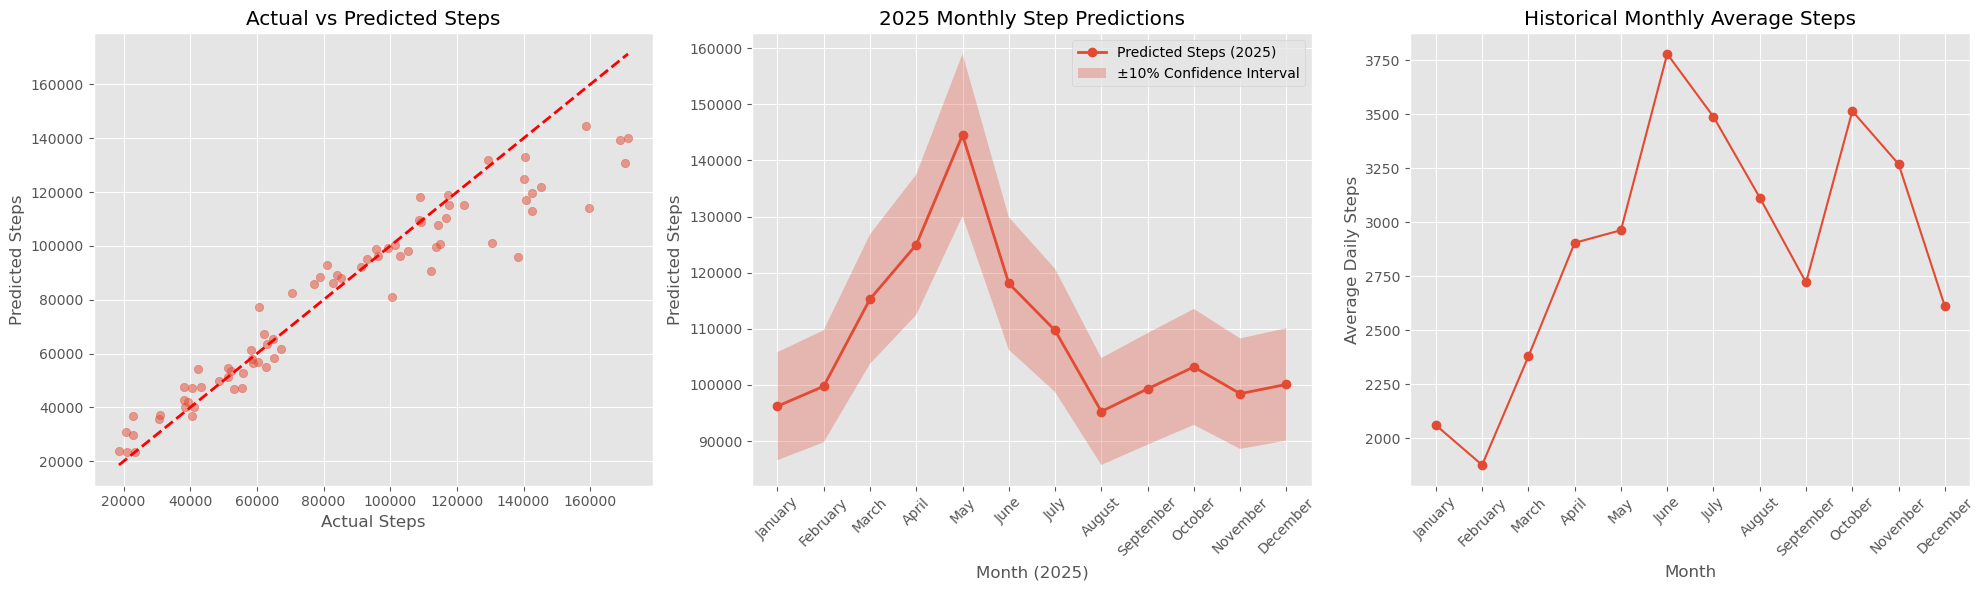

Model Performance on Training Data: MSE = 192345397.23, R² = 0.89


In [25]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

def remove_outliers(df, column, threshold=3):
    z_scores = zscore(df[column])
    abs_z_scores = np.abs(z_scores)
    return df[abs_z_scores < threshold]

daily_steps['year'] = daily_steps['date'].apply(lambda x: x.year)
daily_steps['month'] = daily_steps['date'].apply(lambda x: x.month)
daily_steps['day'] = daily_steps['date'].apply(lambda x: x.day)
daily_steps['day_of_year'] = daily_steps['date'].apply(lambda x: x.timetuple().tm_yday)

covid_start = pd.to_datetime('2020-03-13')
covid_end = pd.to_datetime('2021-03-01')
cleaned_data = daily_steps[~((pd.to_datetime(daily_steps['date']) >= covid_start) & (pd.to_datetime(daily_steps['date']) <= covid_end))]

cleaned_data['date'] = pd.to_datetime(cleaned_data['date'])
cleaned_data = cleaned_data[cleaned_data['date'] <= pd.to_datetime('2024-09-30')]

cleaned_data = remove_outliers(cleaned_data, 'steps', threshold=3)

monthly_data = cleaned_data.groupby(['year', 'month']).agg({'steps': 'sum'}).reset_index()
monthly_data['log_steps'] = np.log1p(monthly_data['steps'])

train_data = monthly_data[monthly_data['year'] < 2025]
test_data = pd.DataFrame({
    'year': [2025] * 12,
    'month': np.arange(1, 13)
})

X_train = train_data[['year', 'month']]
y_train = train_data['log_steps']
X_test = test_data[['year', 'month']]

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

test_data['log_predicted_steps'] = model.predict(X_test)

test_data['predicted_steps'] = np.expm1(test_data['log_predicted_steps'])

test_data['predicted_steps'] = test_data['predicted_steps'].apply(lambda x: max(x, 100))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

ax1.scatter(np.expm1(y_train), np.expm1(model.predict(X_train)), alpha=0.5)
ax1.plot([np.expm1(y_train).min(), np.expm1(y_train).max()], 
         [np.expm1(y_train).min(), np.expm1(y_train).max()], 
         'r--', lw=2)
ax1.set_xlabel('Actual Steps')
ax1.set_ylabel('Predicted Steps')
ax1.set_title('Actual vs Predicted Steps')

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
ax2.plot(test_data['month'], test_data['predicted_steps'], marker='o', label='Predicted Steps (2025)', linewidth=2)
ax2.fill_between(test_data['month'], 
                 test_data['predicted_steps'] * 0.9, 
                 test_data['predicted_steps'] * 1.1, 
                 alpha=0.3, label='±10% Confidence Interval')
ax2.set_xticks(test_data['month'])
ax2.set_xticklabels(months, rotation=45)
ax2.set_xlabel('Month (2025)')
ax2.set_ylabel('Predicted Steps')
ax2.set_title('2025 Monthly Step Predictions')
ax2.legend()
ax2.grid(True)

monthly_avg = cleaned_data.groupby('month')['steps'].mean()
ax3.plot(monthly_avg.index, monthly_avg.values, marker='o')
ax3.set_xticks(monthly_avg.index)
ax3.set_xticklabels(months, rotation=45)
ax3.set_xlabel('Month')
ax3.set_ylabel('Average Daily Steps')
ax3.set_title('Historical Monthly Average Steps')
ax3.grid(True)

plt.tight_layout()
plt.show()

y_pred = model.predict(X_train)
y_pred_original = np.expm1(y_pred)
mse = mean_squared_error(np.expm1(y_train), y_pred_original)
r2 = r2_score(np.expm1(y_train), y_pred_original)
print(f"Model Performance on Training Data: MSE = {mse:.2f}, R² = {r2:.2f}")